# Analysis for statistics between GP and AN phases

## Necessary imports

In [13]:
import numpy as np
import cartopy.crs as ccrs
import cartopy.feature as cf
import cartopy.util as cutil
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import matplotlib.pyplot as plt
import xarray as xr
import cftime

## Useful definitions

In [41]:
def AN_map(ds_to_plt, bounds, name):
    fig, ax = plt.subplots(1, 1, figsize=(10,5),
                           subplot_kw={'projection': ccrs.PlateCarree()})
    fig.subplots_adjust(hspace=0, wspace=0, top=0.925, left=0.1)
    cbar_ax = fig.add_axes([0, 0, 0.1, 0.1])
    # cdat, clon = cutil.add_cyclic_point(ds_to_plt, ds_to_plt.longitude)
    cdat = ds_to_plt
    clat = ds_to_plt.latitude
    clon = ds_to_plt.longitude

    ax.set_title(name)
    lon_ticks = np.arange(bounds[0], bounds[1], 20)
    lat_ticks = np.arange(bounds[2], bounds[3], 10)
    ax.set_xticks(lon_ticks, crs=ccrs.PlateCarree())
    ax.set_yticks(lat_ticks, crs=ccrs.PlateCarree())
    lon_formatter = LongitudeFormatter(zero_direction_label=True)
    lat_formatter = LatitudeFormatter()
    ax.xaxis.set_major_formatter(lon_formatter)
    ax.yaxis.set_major_formatter(lat_formatter)
    ax.add_feature(cf.LAND)
    
    
    def resize_colobar(event):
        plt.draw()

        posn = ax.get_position()
        cbar_ax.set_position([posn.x0 + posn.width + 0.01, posn.y0,
                              0.04, posn.height])
    
    ax.set_extent(bounds, ccrs.PlateCarree())
    sst_contour = ax.contourf(clon, clat, cdat, levels=20, transform=ccrs.PlateCarree(), cmap='YlOrBr')
    fig.canvas.mpl_connect('resize_event', resize_colobar)
    ax.coastlines()
    plt.colorbar(sst_contour, cax=cbar_ax)
    
    resize_colobar(None)
    plt.show()

## Data Import

In [4]:
GP = xr.load_dataset('Data/GP_results.nc')
PI = xr.load_dataset('Data/PI_results.nc')
AN = xr.load_dataset('Data/AN_Index_results.nc')

### check values

In [8]:
GP

<xarray.Dataset>
Dimensions:    (time: 744, latitude: 49, longitude: 95)
Coordinates:
  * time       (time) datetime64[ns] 1958-01-01 1958-02-01 ... 2019-12-01
  * latitude   (latitude) float64 -20.0 -18.75 -17.5 -16.25 ... 37.5 38.75 40.0
  * longitude  (longitude) float64 -1.25 0.0 1.25 2.5 ... 355.0 356.2 357.5
    number     int64 0
    step       timedelta64[ns] 00:00:00
Data variables:
    GP         (time, latitude, longitude) float64 nan nan 0.0006259 ... nan nan

In [7]:
PI

<xarray.Dataset>
Dimensions:    (time: 744, latitude: 49, longitude: 95)
Coordinates:
  * time       (time) datetime64[ns] 1958-01-01 1958-02-01 ... 2019-12-01
  * latitude   (latitude) float64 -20.0 -18.75 -17.5 -16.25 ... 37.5 38.75 40.0
  * longitude  (longitude) float64 -1.25 0.0 1.25 2.5 ... 355.0 356.2 357.5
    step       timedelta64[ns] 00:00:00
    number     int64 0
Data variables:
    VMAX       (time, latitude, longitude) float64 nan nan 10.92 ... nan nan nan
    PMIN       (time, latitude, longitude) float64 nan nan 1.014e+03 ... nan nan
    IFL        (time, latitude, longitude) float64 0.0 0.0 1.0 ... 0.0 0.0 0.0
    TO         (time, latitude, longitude) float64 nan nan 289.2 ... nan nan nan
    LNB        (time, latitude, longitude) float64 nan nan 833.1 ... nan nan nan
Attributes:
    Description:  Calculated tropical cyclone potential intensity

In [6]:
AN

<xarray.Dataset>
Dimensions:    (month: 12, latitude: 144, longitude: 288, time: 744)
Coordinates:
  * time       (time) object 1958-01-15 00:00:00 ... 2019-12-15 00:00:00
  * month      (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
  * latitude   (latitude) float64 -90.0 -88.75 -87.5 -86.25 ... 86.25 87.5 88.75
  * longitude  (longitude) float64 0.5 1.75 3.0 4.25 ... 355.5 356.8 358.0 359.2
Data variables:
    sst_mean   (month, latitude, longitude) float64 nan nan nan ... -1.8 -1.8
    sst_anom   (time, latitude, longitude) float64 nan nan nan ... nan nan nan
    index      (time) float32 nan -0.4375 -0.5987 -1.085 ... 0.9143 1.174 nan
    atln_anom  (latitude, longitude) float64 nan nan nan nan ... 0.0 0.0 0.0 0.0
Attributes:
    Description:  Results from ATLN_Index.ipynb script based on HadiSST data.

## Simple Plots

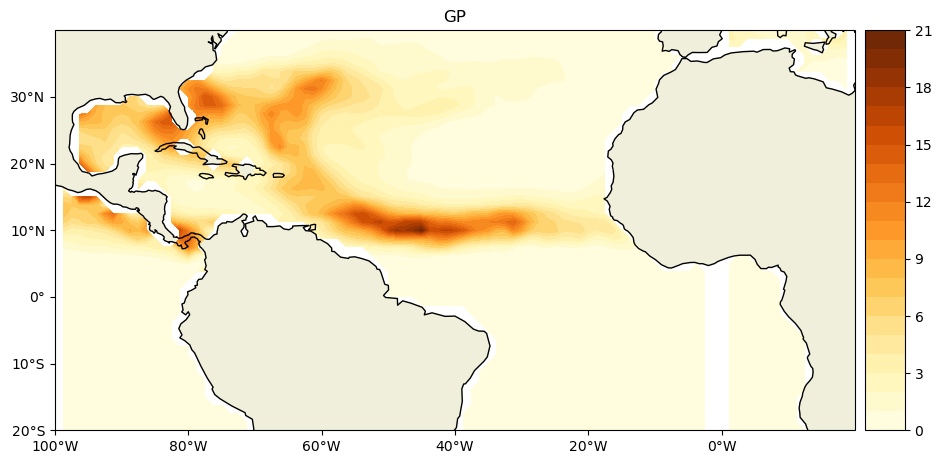

In [42]:
box = [-100, 20, -20, 40]
AN_map(GP.GP[8], box, 'GP')

## Correlations